In [1]:
%load_ext autoreload
%autoreload 2
%pdb
%matplotlib inline

Automatic pdb calling has been turned ON


In [2]:
import matplotlib
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 18})
from collections import defaultdict, OrderedDict

from utils.generic import init_params
from main.seir.optimiser import Optimiser
from models.seir.seir_testing import SEIR_Testing
from data.processing import get_district_time_series
from data.dataloader import get_covid19india_api_data

## Load covid19 data

In [3]:
dataframes = get_covid19india_api_data()

In [4]:
dataframes.keys()

dict_keys(['df_tested', 'df_statewise', 'df_india_time_series', 'df_districtwise', 'df_raw_data', 'df_raw_data_2', 'df_travel_history', 'df_resources'])

In [5]:
df_district = get_district_time_series(dataframes)

In [6]:
## TODO: Make splits
df_train = df_district

## Loss Calculation Functions

In [7]:
def _calc_rmse(y_pred, y_true, log=True):
    if log:
        y_true = np.log(y_true)
        y_pred = np.log(y_pred)
    loss = np.sqrt(np.mean((y_true - y_pred)**2))
    return loss

def _calc_mape(y_pred, y_true):
    y_pred = y_pred[y_true > 0]
    y_true = y_true[y_true > 0]

    ape = np.abs((y_true - y_pred + 0) / y_true) *  100
    loss = np.mean(ape)
    return loss

def calc_loss_dict(states_time_matrix, df, method='rmse', rmse_log=False):
    pred_hospitalisations = states_time_matrix[6] + states_time_matrix[7] + states_time_matrix[8]
    pred_recoveries = states_time_matrix[9]
    pred_fatalities = states_time_matrix[10]
    pred_infectious_unknown = states_time_matrix[2] + states_time_matrix[4]
    pred_total_cases = pred_hospitalisations + pred_recoveries + pred_fatalities
    
    if method == 'rmse':
        if rmse_log:
            calculate = lambda x, y : _calc_rmse(x, y)
        else:
            calculate = lambda x, y : _calc_rmse(x, y, log=False)
    
    if method == 'mape':
            calculate = lambda x, y : _calc_mape(x, y)
    
    losses = {}
#     losses['hospitalised'] = calculate(pred_hospitalisations, df['Hospitalised'])
#     losses['recovered'] = calculate(pred_recoveries, df['Recovered'])
#     losses['fatalities'] = calculate(pred_fatalities, df['Fatalities'])
#     losses['active_infections'] = calculate(pred_infectious_unknown, df['Active Infections (Unknown)'])
    losses['total'] = calculate(pred_total_cases, df['total_infected'])
    
    return losses

def calc_loss(states_time_matrix, df, method='rmse', rmse_log=False):
    losses = calc_loss_dict(states_time_matrix, df, method, rmse_log)
#     loss = losses['hospitalised'] + losses['recovered'] + losses['total'] + losses['active_infections']
    loss = losses['total']
    return loss

## Initialize params and state values

In [8]:
vanilla_params, testing_params, state_init_values = init_params()

In [9]:
vanilla_params

{'R0': 2.2,
 'T_trans': 1.3181818181818181,
 'T_inc': 5.2,
 'T_inf': 2.9,
 'T_recov_mild': 11.1,
 'T_recov_severe': 28.6,
 'T_hosp': 5,
 'T_death': 32,
 'P_mild': 0.78,
 'P_severe': 0.2,
 'P_fatal': 0.02,
 'intervention_day': 100,
 'lockdown_removal_day': 45,
 'intervention_amount': 0.33,
 'N': 7000000.0}

In [10]:
state_init_values

OrderedDict([('S', 0.9999998571428571),
             ('E', 0),
             ('I', 1.4285714285714285e-07),
             ('D_E', 0),
             ('D_I', 0),
             ('R_mild', 0),
             ('R_severe_home', 0),
             ('R_severe_hosp', 0),
             ('R_fatal', 0),
             ('C', 0),
             ('D', 0)])

## Set priors for parameters of interest

In [11]:
## assuming uniform priors, following dictionary contains the ranges
prior_ranges = OrderedDict()
prior_ranges['R0'] = (1.6, 3)
prior_ranges['T_inc'] = (4, 5)
prior_ranges['T_inf'] = (3, 4)
prior_ranges['T_recov_severe'] = (9, 20)
prior_ranges['P_severe'] = (0.3, 0.99)
prior_ranges['intervention_amount'] = (0.3, 1)

def param_init():
    theta = defaultdict()
    for key in prior_ranges:
        theta[key] = np.random.uniform(prior_ranges[key][0], prior_ranges[key][1])
        
    return theta

## Proposal function to sample theta_new given theta_old

In [13]:
proposal_sigmas = OrderedDict()
for key in prior_ranges:
    proposal_sigmas[key] = 0.25 * (prior_ranges[key][1] - prior_ranges[key][0])

def proposal(theta_old):
    theta_new = np.random.normal(loc=[*theta_old.values()], scale=[*proposal_sigmas.values()])
    return dict(zip(theta_old.keys(), theta_new))

## Log Likelihood and Prior

In [14]:
def log_likelihood(theta):
    if (np.array([*theta.values()]) < 0).any():
        return -np.inf
    alpha = 0.01
    optimiser = Optimiser()
    default_params = optimiser.init_default_params(df_train)
    df_prediction = optimiser.solve(theta, default_params, df_train)
    pred = np.array(df_prediction['total_infected'])
    true = np.array(df_train['total_infected'])
    sigma = alpha * true.std()
    N = len(true)
    ll = - (N * np.log(np.sqrt(2*np.pi) * sigma)) - (np.sum(((true - pred) ** 2) / (2 * sigma ** 2)))
    return ll

def log_prior(theta):
#     prior = 1
#     for key in prior_ranges:
#         if in_valid_range(key, theta[key]):
#             prior *= 1 / (prior_ranges[key][1] - prior_ranges[key][0])
#         else:
#             prior = 0
#             break
    if (np.array([*theta.values()]) < 0).any():
        prior = 0
    else:
        prior = 1
    
    return np.log(prior)

def in_valid_range(key, value):
    return (value <= prior_ranges[key][1]) and (value >= prior_ranges[key][0])

## Acceptance function

In [15]:
def accept(theta_old, theta_new):    
    x_new = log_likelihood(theta_new) + log_prior(theta_new)
    x_old = log_likelihood(theta_old) + log_prior(theta_old)
    
    if (x_new) > (x_old):
        return True
    else:
        x = np.random.uniform(0, 1)
        return (x < np.exp(x_new - x_old))

## Metropolis loop

In [17]:
def metropolis(iter=1000):
    theta = param_init()
    accepted = [theta]
    rejected = list()
    
    for i in tqdm(range(iter)):
        theta_new = proposal(theta)
        if accept(theta, theta_new):
            theta = theta_new
        else:
            rejected.append(theta_new)
        accepted.append(theta)
    
    return accepted, rejected

In [18]:
acc, rej = metropolis(iter=10000)

  0%|          | 17/10000 [00:00<05:53, 28.24it/s]<ipython-input-14-aceb16487e73>:28: RuntimeWarning: divide by zero encountered in log
  return np.log(prior)
100%|██████████| 10000/10000 [06:31<00:00, 25.53it/s]


In [19]:
df_samples = pd.DataFrame(acc)

In [20]:
df_samples

,R0,T_inc,T_inf,T_recov_severe,P_severe,intervention_amount
0,2.652502,4.141709,3.503888,9.347330,0.354051,0.743089
1,2.293678,3.991899,3.364489,8.048319,0.253204,0.897155
2,2.293678,3.991899,3.364489,8.048319,0.253204,0.897155
3,2.293678,3.991899,3.364489,8.048319,0.253204,0.897155
4,2.293678,3.991899,3.364489,8.048319,0.253204,0.897155
...,...,...,...,...,...,...
9996,2.304654,5.166053,0.994537,14.275650,0.838763,0.358527
9997,2.304654,5.166053,0.994537,14.275650,0.838763,0.358527
9998,2.304654,5.166053,0.994537,14.275650,0.838763,0.358527
9999,2.304654,5.166053,0.994537,14.275650,0.838763,0.358527


Text(0.5, 1.0, 'Parameter samples obtained from MCMC')

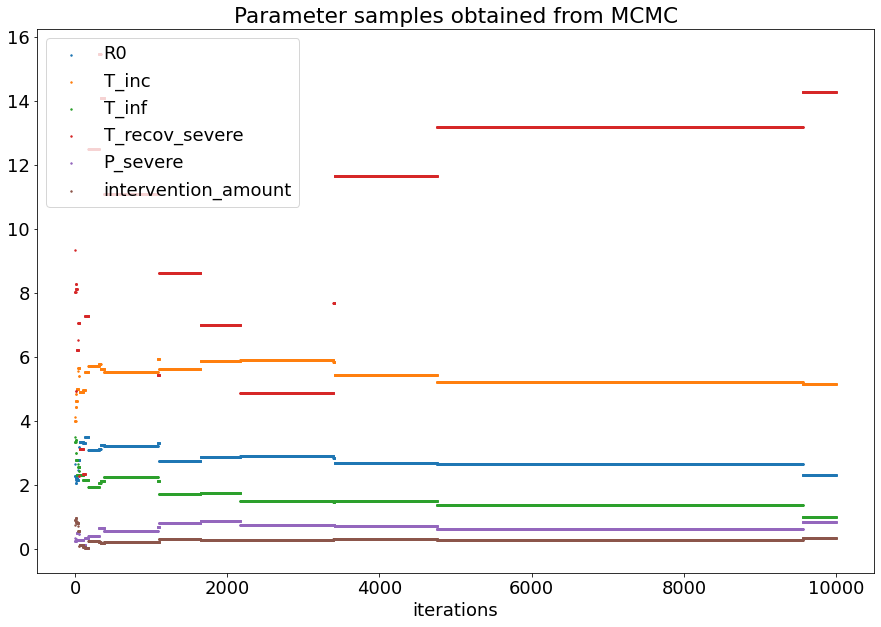

In [21]:
plt.figure(figsize=(15, 10))
for param in df_samples.columns:
    plt.scatter(list(range(len(df_samples[param]))), df_samples[param], label=param, s=2)
plt.xlabel("iterations")
plt.legend()
plt.title("Parameter samples obtained from MCMC")

In [22]:
rej_samples = pd.DataFrame(rej)

Text(0.5, 1.0, 'Rejected Parameter samples obtained from MCMC')

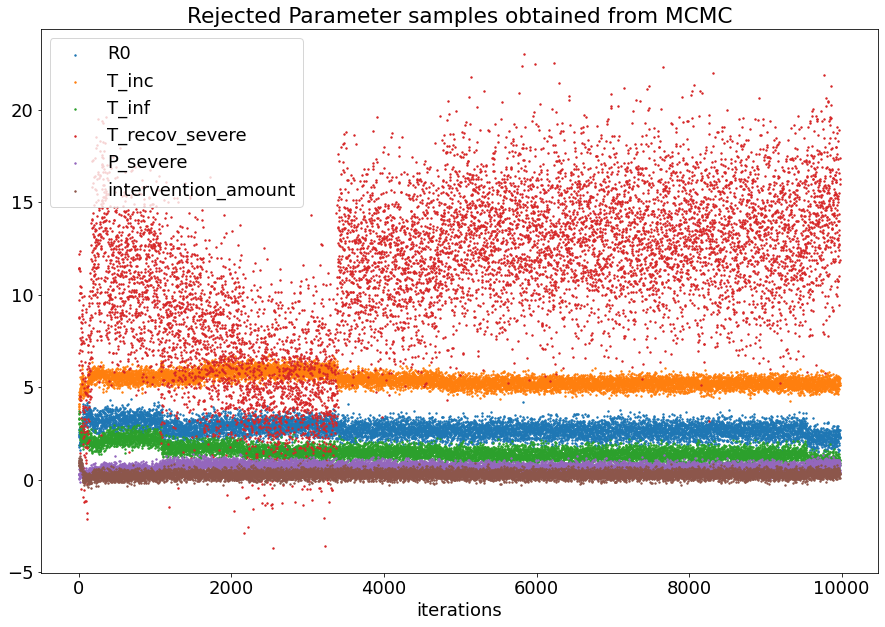

In [23]:
plt.figure(figsize=(15, 10))
for param in rej_samples.columns:
    plt.scatter(list(range(len(rej_samples[param]))), rej_samples[param], label=param, s=2)
plt.xlabel("iterations")
plt.legend()
plt.title("Rejected Parameter samples obtained from MCMC")

(array([4.000e+00, 2.000e+01, 1.100e+01, 4.440e+02, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 6.154e+03, 5.420e+02, 2.800e+01, 1.747e+03,
        0.000e+00, 0.000e+00, 1.600e+02, 2.000e+00, 7.500e+02, 9.400e+01,
        0.000e+00, 4.400e+01]),
 array([2.05583645, 2.12842502, 2.20101358, 2.27360214, 2.34619071,
        2.41877927, 2.49136783, 2.5639564 , 2.63654496, 2.70913352,
        2.78172209, 2.85431065, 2.92689921, 2.99948778, 3.07207634,
        3.1446649 , 3.21725347, 3.28984203, 3.36243059, 3.43501916,
        3.50760772]),
 <a list of 20 Patch objects>)

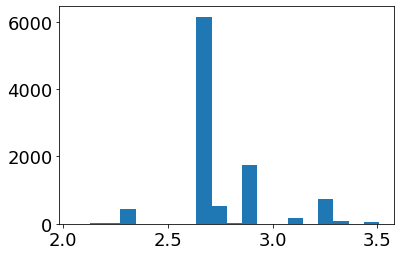

In [24]:
plt.hist(df_samples['R0'], bins=20)

## Use samples to estimate confidence intervals

In [31]:
pred_dfs = list()
optimiser = Optimiser()
default_params = optimiser.init_default_params(df_train)

In [32]:
burn_in = 500
n_samples = 1000
acc = acc[burn_in:]
sample_indices = np.random.uniform(0, len(acc), n_samples)
for i in tqdm(sample_indices):
    pred_dfs.append(optimiser.solve(acc[int(i)], default_params, df_train))

100%|██████████| 1000/1000 [00:19<00:00, 52.32it/s]


In [33]:
for df in pred_dfs:
    df.set_index('date', inplace=True)

In [40]:
result = pred_dfs[0].copy()
for col in result.columns:
    result["{}_low".format(col)] = ''
    result["{}_high".format(col)] = ''

In [41]:
def get_PI(date, key, multiplier=1.96):
    pred_samples = list()
    for df in pred_dfs:
        pred_samples.append(df.loc[date, key])
        
    mu = np.array(pred_samples).mean()
    sigma = np.array(pred_samples).std()
    low = mu - multiplier*sigma
    high = mu + multiplier*sigma
    return mu, low, high

In [42]:
for date in tqdm(pred_dfs[0].index):
    for key in pred_dfs[0]:
        result.loc[date, key], result.loc[date, "{}_low".format(key)], result.loc[date, "{}_high".format(key)] = get_PI(date, key)

100%|██████████| 48/48 [00:06<00:00,  7.88it/s]


## Visualize the intervals

Text(0, 0.5, 'Total infected')

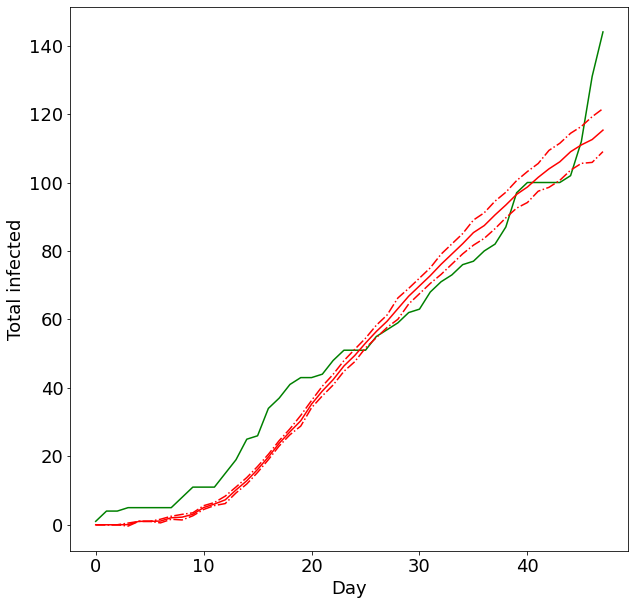

In [43]:
plt.figure(figsize=(10, 10))
plt.plot(df_train['total_infected'], c='g', label='Actual')
plt.plot(result['total_infected'].tolist(), c='r', label='Estimated')
plt.plot(result['total_infected_low'].tolist(), c='r', linestyle='dashdot')
plt.plot(result['total_infected_high'].tolist(), c='r', linestyle='dashdot')
plt.xlabel("Day")
plt.ylabel("Total infected")